# ROADMAP
 - funzioni per scrivere i log senza dipendenze specifiche del pacchetto mio

# Importa modulo per grafici training in tempo reale

In [1]:
import requests
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/atancredi/NotebookRealTimePlotting/master/Core.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('Core.py', 'w') as f:
    f.write(r.text)

# now we can import
import Core as realtimegraph

# Configurazione

In [3]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.5 MB/s 


In [4]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchmetrics
from torchmetrics import AUROC
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import TensorDataset
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [5]:
# Device recognition - se posso sposto tutto su GPU
def DeviceRecognition():
  if torch.cuda.is_available():
    print('Numero di GPU disponibili: ',torch.cuda.device_count())
    for i in range(0,torch.cuda.device_count()):
      print(torch.cuda.get_device_name(0))
  device = ('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Computation device: {device}\n")
  return device

device = DeviceRecognition()

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Definiamo la loss function, e la metricae per monitorare il training


# loss function 
loss_func = nn.CrossEntropyLoss() 

# metric accuracy (in questo caso dobbiamo scrivercela da noi perché non è disponibile builtin in pytorch)
def accuracy(yhat, y):
    preds = torch.max(yhat,1)[1] #predizioni == neuroni con la massima probabilità
    batch_acc = (preds == y).sum()
    return batch_acc

metric_func = accuracy

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")

            display(Javascript('writeLog("Best validation loss: '+str(self.best_valid_loss)+'")'))
            display(Javascript('writeLog("saving best model for epoch: '+str(epoch+1)+'")'))

            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pt')

# Importa dati

In [8]:
# Calcolo matrice di correlazione
def CorrelationMatrix(data, title):
  print(title)
  #matrice di correlazione
  corrmatrix=np.corrcoef(data.transpose())
  print("Correlation Matrix Dimensions: "+str(corrmatrix.shape))
  plt.matshow(corrmatrix)
  plt.gca().xaxis.tick_bottom()
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  plt.title(title, fontsize=12)
  plt.show()

def CheckLabelBalance(label):
  check=0
  for i in range(len(label)):
    if label[i]>0.5:
      check+=1
  check/=len(label)
  print("label balance check result:",check) #output binario, se esce 0.5 ->bilanciato

def ImportatoreDatiBassoLivello(tipo, skipBalanceCheck = False):

  print("####################################################")
  
  Neve = 100000 #scelto 600k com massimo della ram disponibile, di più faceva crashare

  number = 10000000
  temp_shape = Neve
  if tipo == "test":
    number = 5000000
    temp_shape = -1
  
  with h5py.File("/content/drive/MyDrive/dataset_pr5/images/"+tipo+"_pile_"+str(number)+".h5",'r') as hdf:
    ls = list(hdf.keys())
    print('dataset nel file: \n', ls)
    features = np.array(hdf.get('features')[:Neve]).reshape(temp_shape,32,32)
    targets = np.array(hdf.get('targets')[:Neve]).reshape(temp_shape)

  print("Shapes")
  print(features.shape)
  print(targets.shape)

  #plotto degli esempi

  plt.figure(figsize=(5,5))
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(features[i], cmap='Greys')
    ax.set_title(targets[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.tight_layout()

  if not skipBalanceCheck:
    print("Check label's balance (if 0.5 == balance)")
    CheckLabelBalance(targets)

  return features, targets

def ImportatoreDatiAltoLivello(tipo, skipBalanceCheck = False):

  print("####################################################")

  number = 10000000
  if tipo == "test":
    number = 5000000

  data = np.array(h5py.File("/content/drive/MyDrive/dataset_pr5/highlevel/"+tipo+"_pile_"+str(number)+".h5")["features"])
  label = np.array(h5py.File("/content/drive/MyDrive/dataset_pr5/highlevel/"+tipo+"_pile_"+str(number)+".h5")["targets"])

  CorrelationMatrix(data,tipo+" Feature Correlation")
  print("Dimensional control:")
  print(data.shape)

  if not skipBalanceCheck:
    print("Check label's balance (if 0.5 == balance)")
    CheckLabelBalance(label)

  data = data.reshape((data.shape[0], 6)).astype("float32")
  label = label.reshape((-1)).astype('int64')

  #Reduce dataset dimensions by 40%
  data, _, label, _ = train_test_split(data, label, test_size=0.6, shuffle=True, random_state=42)

  #Check datasets dimensions
  print("Check dataset's dimensions - "+tipo)
  print(data.shape)
  print(label.shape)

  # solo hilevel
  data = data.reshape(-1, 6)

  return data, label

def CreaDataloader(tipo, level,skipBalanceCheck = False, batch_size = 1000):
  if level == "hi":
    x, y = ImportatoreDatiAltoLivello(tipo, skipBalanceCheck)
    return DataLoader(TensorDataset(torch.from_numpy(x),torch.from_numpy(y)), batch_size = batch_size)
  
  if level == "lo":
    x, y = ImportatoreDatiBassoLivello(tipo, skipBalanceCheck)
    x = torch.from_numpy(x.reshape((-1,32,32,1)).astype("float32")).permute(0,3,1,2)
    y = torch.from_numpy(y.reshape((-1)).astype('int64'))
    return DataLoader(TensorDataset(x,y), batch_size = batch_size)

def DataProcessing(level = "", skipBalanceCheck = False):
  train = {}
  test = {}

  if level == "hi":
    train["hi"] = CreaDataloader("train","hi", skipBalanceCheck)
    test["hi"] = CreaDataloader("test","hi", skipBalanceCheck)
  
  elif level == "lo":
    train["lo"] = CreaDataloader("train","lo", skipBalanceCheck)
    test["lo"] = CreaDataloader("test","lo", skipBalanceCheck)
  
  else:
    train["hi"] = CreaDataloader("train","hi", skipBalanceCheck)
    test["hi"] = CreaDataloader("test","hi", skipBalanceCheck)
    train["lo"] = CreaDataloader("train","lo", skipBalanceCheck)
    test["lo"] = CreaDataloader("test","lo", skipBalanceCheck)
  
  return train,test

####################################################
train Feature Correlation
Correlation Matrix Dimensions: (6, 6)


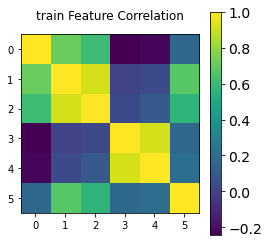

Dimensional control:
(10000000, 6)
Check dataset's dimensions - train
(4000000, 6)
(4000000,)
####################################################
test Feature Correlation
Correlation Matrix Dimensions: (6, 6)


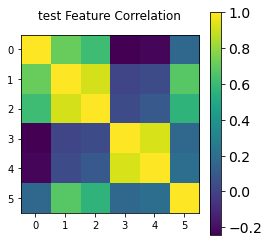

Dimensional control:
(5000000, 6)
Check dataset's dimensions - test
(2000000, 6)
(2000000,)
####################################################
dataset nel file: 
 ['features', 'targets']
Shapes
(100000, 32, 32)
(100000,)
####################################################
dataset nel file: 
 ['features', 'targets']
Shapes
(100000, 32, 32)
(100000,)


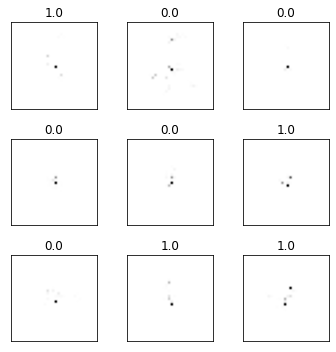

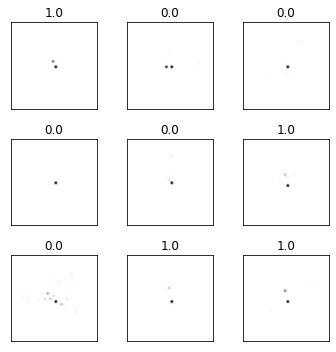

In [9]:
train, test = DataProcessing("",True)

# Convolutional Neural Network

In [10]:
SM=torch.nn.Softmax(dim=1)

batch_size = 1000

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # definizione dei layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3))
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))

    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    
    # MLP
    self.flatten = nn.Flatten() #flatten layer
    self.drop = nn.Dropout(p=0.5) #droput 

    self.fc1 = nn.Linear(in_features=128, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=2)

  # forward pass: x (input) -> out  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)

    #flatten
    x = self.flatten(x)

    x = self.drop(x)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    out=x

    return out
  
# printout del modello

cnn = CNN()

if torch.cuda.is_available():
  print("cuda")
  summary(cnn.cuda(), input_size=(1,32,32))
else:
  summary(cnn, input_size=(1,32,32))



cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
         MaxPool2d-2           [-1, 16, 15, 15]               0
            Conv2d-3           [-1, 16, 13, 13]           2,320
         MaxPool2d-4             [-1, 16, 6, 6]               0
            Conv2d-5             [-1, 32, 4, 4]           4,640
         MaxPool2d-6             [-1, 32, 2, 2]               0
           Flatten-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
           Linear-12                    [-1, 2]             258
Total params: 73,298
Trainable params: 73,298
Non-trainable params: 0
----------------------------

In [11]:
#Test del dataloader

feat, label = next(iter(train["lo"]))

feat=feat.to(device)
label=label.to(device)

out = cnn(feat)

print(out.shape)
for i in range(10):
  print(out[i])

# ottmizzatore: usiamo per esempio la discesa stocastica lungo il gradiente con momentum
from torch import optim
opt = optim.Adam(cnn.parameters(),betas=(0.9, 0.999),weight_decay=1e-5, lr=0.001)
# aggiungiamo uno scheduler per il LR che diminusice il LR sui plateu
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-10, verbose=True)
print(opt.param_groups[0]['lr'])


torch.Size([1000, 2])
tensor([-0.1347, -1.9635], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.3605, -0.1704], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.2195, -2.3306], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.2431, -1.8915], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0378, -0.7078], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.1004, -0.9075], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0558, -0.6427], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.2314, -0.1947], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0364, -1.1242], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.5810, -1.6872], device='cuda:0', grad_fn=<SelectBackward0>)
0.001


In [12]:
import IPython
import numpy as np
from IPython.display import display, HTML, Javascript
import time
import random

realtimegraph.configure_browser_state()

import time
cnn.to(device)
save_best_model = SaveBestModel()

# numero di epoche
epochs = 200 #Possiamo fermare l'allenamento quando vogliamo, 200 è solo un numero grande
temp=1 #LOSS a epocha zero, mi serve nel loop e la Loss è sempre minore di 1 nei nostri test

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []
#auroc
auroc = AUROC(num_classes=2)


# loop sulle epoche
for epoch in range(epochs):
    display(Javascript('writeLog("--------------------")'))
    t0 = time.time()

    display(Javascript('writeLog("start epoch '+str(epoch+1)+'")'))

    # training step (in cui aggiorniamo i pesi della rete neurale)
    cnn.train()
    train_loss = 0
    train_metric = 0
    train_AUC=0
    counter = 0

    display(Javascript('writeLog("start training step")'))
    for xb, yb in train["lo"]:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = cnn(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)


        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()


        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch_size)

    hist_loss.append(train_loss)
    hist_metric.append(train_metric)
    
    #grafico in tempo reale della train loss e della train metric
    display(Javascript('addData('+str(epoch+1)+','+str(train_loss)+','+str(train_metric)+')'))

    # validation step (non vengono aggiornati i pesi)
    display(Javascript('writeLog("-------")'))
    display(Javascript('writeLog("start validation step")'))
    cnn.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in test["lo"]:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = cnn(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)

        vali_loss += vloss.item()
        vali_metric += vmetric.item() 

 

    vali_loss /= counter
    vali_metric /= (counter*batch_size)
 
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)



    #update learning rate schedule
    #print("Current LR:",opt.param_groups[0]['lr'],"Delta Vali Loss:",temp-vali_loss)   
    display(Javascript('writeLog("Current LR: '+str(opt.param_groups[0]['lr'])+', Delta Vali Loss: '+str(temp-vali_loss)+')'))
    scheduler.step(vali_loss) 
    temp=vali_loss

    #save best model
    save_best_model(vali_loss, epoch, cnn, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    #print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
    #      % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    display(Javascript('writeLog("epoch: '+str(epoch+1)+', time(s): '+str(elapsed_time)+', train loss: '+str(train_loss)+', train metric: '+str(train_metric)+', vali loss: '+str(vali_loss)+', vali metric: '+str(vali_metric)+'")'))
    

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

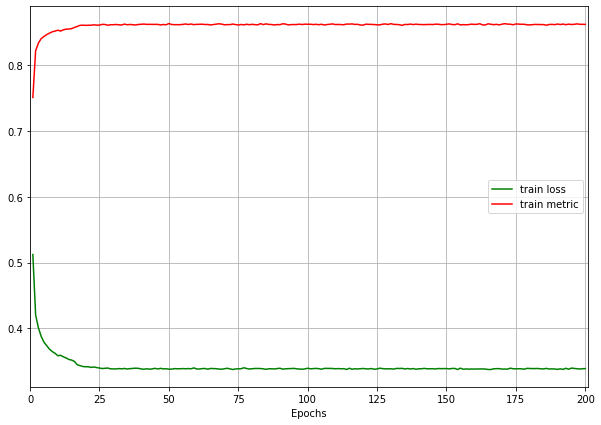

0.9303167819976806
0.0
torch.Size([1000, 2])
0.91
------
<class 'numpy.ndarray'>
-------------


In [ ]:
from matplotlib.markers import MarkerStyle
# grafico accuracy vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1),hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='red', linestyle='-', label='train metric')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()
ax = plt.gca()
ax.set_xlim([0,len(hist_metric)+1])
plt.grid()
#ax.set_ylim([0, 1])
plt.show()

#AUC
cnn.eval()
vali_auc=0
counter = 0
count=0
with torch.no_grad(): 
  for xb, yb in test["lo"]:
    counter += 1
    xb=xb.to(device)
    yb=yb.to(device)

    pred = cnn(xb) #predizione del modello
    vAUC=auroc(pred, yb)
    vali_auc += vAUC.item() 

    

vali_auc/=counter
print(vali_auc)
print(count/100000)

#Test del modello e check delle probabilita 

feat, label = next(iter(test["lo"]))

feat=feat.to(device)
label=label.to(device)

out = cnn(feat)

print(out.shape)

out=out.to("cpu")
out=out.detach()
out=out.numpy()
#print(out)
risultati=[]
for i in range(100):
  if out[i,0]>out[i,1]:
    risultati.append(0)
  else:
    risultati.append(1)
risultati=np.array(risultati)
labels=label.cpu().detach().numpy()

check=0
len2=100
for i in range(len2):

  if risultati[i]==labels[i]:
    #print("ok")
    check+=1
  else:
    check+=0
    #print("err")

print(check/len2)
print("------")
print(type(out))

for i in range(len(out)):
 e1=(np.e**out[i,0]/(np.e**out[i,0]+np.e**out[i,1]))
 e2=(np.e**out[i,1]/(np.e**out[i,0]+np.e**out[i,1]))
 etot=e1+e2
 if etot < 0.999 or etot > 1.001:
   print("etot non è 1")
   print(e1,e2,etot)#etot deve essere 1
print("-------------")



In [ ]:
#Calcolo confusion matrix e BR=10-->EF
from sklearn.metrics import confusion_matrix

soglia=0.7
cnn.eval()



lista=[0.53,0.54,0.55,0.56]
for soglia in lista:
  TN=0
  FP=0
  FN=0
  TP=0
  counter = 0
  with torch.no_grad(): 
    for xb, yb in test["lo"]:
      PREDIZIONI=[]
      counter += 1
      xb=xb.to(device)
      out = cnn(xb)
      out=out.to("cpu")
      out=out.detach()
      out=out.numpy()
      for i in range(len(out)):
        e1=(np.e**out[i,0]/(np.e**out[i,0]+np.e**out[i,1]))
        e2=(np.e**out[i,1]/(np.e**out[i,0]+np.e**out[i,1]))
        if(e2>=soglia):
          PREDIZIONI.append(1)
          counter+=1
        else:
          PREDIZIONI.append(0)
          counter-=1

  
      yb=yb.detach()
      yb=yb.numpy()  
      
      predict=np.array(PREDIZIONI)

      tn, fp, fn, tp = confusion_matrix(yb, predict).ravel()    
      TN+=tn
      FP+=fp
      FN+=fn
      TP+=tp
  BE=FP/(TN+FP)
  SE=TP/(TP+FN)
  print("-------------")
  print("soglia:",soglia)
  print(TP,FP)
  print(FN,TN)
  print("BR:",BE**-1)
  print("SE:",SE)
print("-------------")





-------------
soglia: 0.53
41288 5469
8712 44531
BR: 9.1424392027793
SE: 0.82576
-------------
soglia: 0.54
41008 5273
8992 44727
BR: 9.482268158543524
SE: 0.82016
-------------
soglia: 0.55
40721 5103
9279 44897
BR: 9.798157946306095
SE: 0.81442
-------------
soglia: 0.56
40439 4942
9561 45058
BR: 10.117361392148927
SE: 0.80878
-------------
